# Import

In [16]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
!tar -xvf  '/content/drive/MyDrive/aclImdb_v1.tar.gz' -C '/content'

Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclI

# Приведем датасеты к удобному виду

Создадим 1 датафрейм с отзывами для обучения

In [20]:
from os import listdir


path = '/content/aclImdb/train/neg'

files = [f for f in listdir(path) if f.split('.')[-1] == 'txt']
d = {'text':[],'score':[],'label':[]}
for file_name in files:
  with open(f'/content/aclImdb/train/neg/{file_name}') as f:
    lines = f.readlines()
  d['text'].append(lines[0])
  d['score'].append(file_name.split('.')[0].split('_')[-1])
  d['label'].append(0)

path = '/content/aclImdb/train/pos'
files = [f for f in listdir(path) if f.split('.')[-1] == 'txt']
for file_name in files:
  with open(f'/content/aclImdb/train/pos/{file_name}') as f:
    lines = f.readlines()
  d['text'].append(lines[0])
  d['score'].append(file_name.split('.')[0].split('_')[-1])
  d['label'].append(1)

data = pd.DataFrame(d)
data = data.sample(frac=1).reset_index(drop=True)

Аналогично для тестирования

In [21]:
path = '/content/aclImdb/test/neg'

files = [f for f in listdir(path) if f.split('.')[-1] == 'txt']
d = {'text':[],'score':[],'label':[]}
for file_name in files:
  with open(f'/content/aclImdb/test/neg/{file_name}') as f:
    lines = f.readlines()
  d['text'].append(lines[0])
  d['score'].append(file_name.split('.')[0].split('_')[-1])
  d['label'].append(0)

path = '/content/aclImdb/test/pos'
files = [f for f in listdir(path) if f.split('.')[-1] == 'txt']
for file_name in files:
  with open(f'/content/aclImdb/test/pos/{file_name}') as f:
    lines = f.readlines()
  d['text'].append(lines[0])
  d['score'].append(file_name.split('.')[0].split('_')[-1])
  d['label'].append(1)

data_test = pd.DataFrame(d)
data_test  = data_test .sample(frac=1).reset_index(drop=True)

In [22]:
data_test

,text,score,label
0,"""Eighteen"" (2004) tells the story of Pip Ander...",7,1
1,I am afraid I will have to add my name to the ...,9,1
2,I've read that Paolo Sorrintino's inspiration ...,7,1
3,Copy cats have copied this movie from a 1974 H...,1,0
4,"I was really excited when I read ""The Cantervi...",2,0
...,...,...,...
24995,Or at least you feel pretty high after this mo...,9,1
24996,At least for me. I have been following the car...,3,0
24997,I knew little of this movie when I entered the...,7,1
24998,"There's some nice scenery to look at here,if y...",1,0


In [23]:
data_test.text[3]

'Copy cats have copied this movie from a 1974 Hindi movie called "Call Girl"! "Call Girl" had an identical story line. The way in which the protagonists fall in love, then rebel and the climax all same in both these films! "Call Girl" is better than Water, at least from the story telling point of view. It was not as agonizingly slow as Water! Water on the contrary does not progresses at all. The aim is perhaps to make the audience sympathize with Kalyani for ever! Are Indian film makers any better than just being great copiers these days? Well they call it "being inspired". In their language it is: "getting inspired (without any citation that is!)"! :)'

#EDA

In [24]:
data

,text,score,label
0,In my opinion this movie advances no new thoug...,3,0
1,I scooped up this title by accident with the G...,8,1
2,"This movie isn't very good. It's boring, and n...",3,0
3,Kabei: Our Mother (2008) is a poetic and subli...,10,1
4,"""Ardh Satya"" is one of the finest film ever ma...",8,1
...,...,...,...
24995,Once again the two bickering professors must j...,10,1
24996,Italian horror/suspense film about a wealthy E...,4,0
24997,"one may ask why? the characters snarl, yell, a...",1,0
24998,"after just having watched The Deer Hunter,whic...",10,1


In [25]:
data = data.astype({'score': 'int32'})

In [26]:
data.describe()

,score,label
count,25000.000000,25000.00000
mean,5.477720,0.50000
std,3.466477,0.50001
min,1.000000,0.00000
25%,2.000000,0.00000
50%,5.500000,0.50000
75%,9.000000,1.00000
max,10.000000,1.00000


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   score   25000 non-null  int32 
 2   label   25000 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 488.4+ KB


Взглянем на распределение оценок

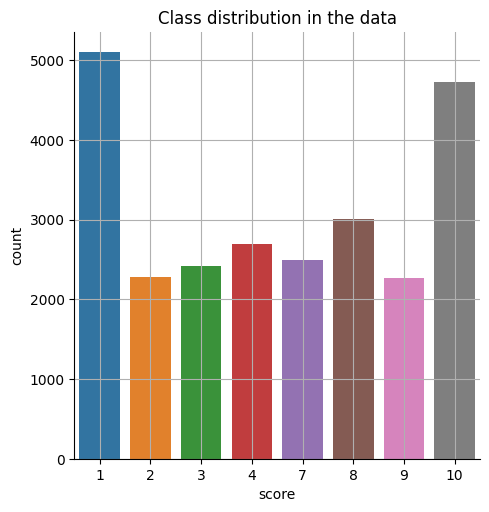

In [28]:
g = sns.catplot(x="score",
                kind="count",
                data=data.sort_values("score"))
plt.grid()
plt.title("Class distribution in the data");

Видим, что среди оценок преобладают `1` и  `10`

## Лемматизация

In [32]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")
mystopwords = stopwords.words('english')

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [33]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, data['text']), total=len(data)))

data['text_lemmas'] = lemmas

100%|██████████| 25000/25000 [01:35<00:00, 260.77it/s]


In [34]:
from multiprocessing import Pool as PoolSklearn
#test
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, data_test['text']), total=len(data_test)))

data_test['text_lemmas'] = lemmas

100%|██████████| 25000/25000 [01:32<00:00, 269.10it/s]


In [ ]:
data.info()

Сначала решим задачу класификации комментарием на позитивные и негативный

Применим различные способы векторизации текста

## CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
data_vec_cv = vectorizer.fit_transform(data['text_lemmas'])

### Посмотрим на данные

In [ ]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2)

In [ ]:
pca.fit(data_vec_cv)

TruncatedSVD()

In [ ]:
data_2  = pca.transform(data_vec_cv)

In [ ]:
df = pd.DataFrame(dict(x=data_2[:,0], y=data_2[:,1],label=data['label'].tolist()))
groups = df.groupby('label',sort=False)

In [ ]:
cluster_colors = {0: 'tab:blue', 1: 'tab:orange'}
cluster_names = {0: 'nigative', 1: 'positive'}

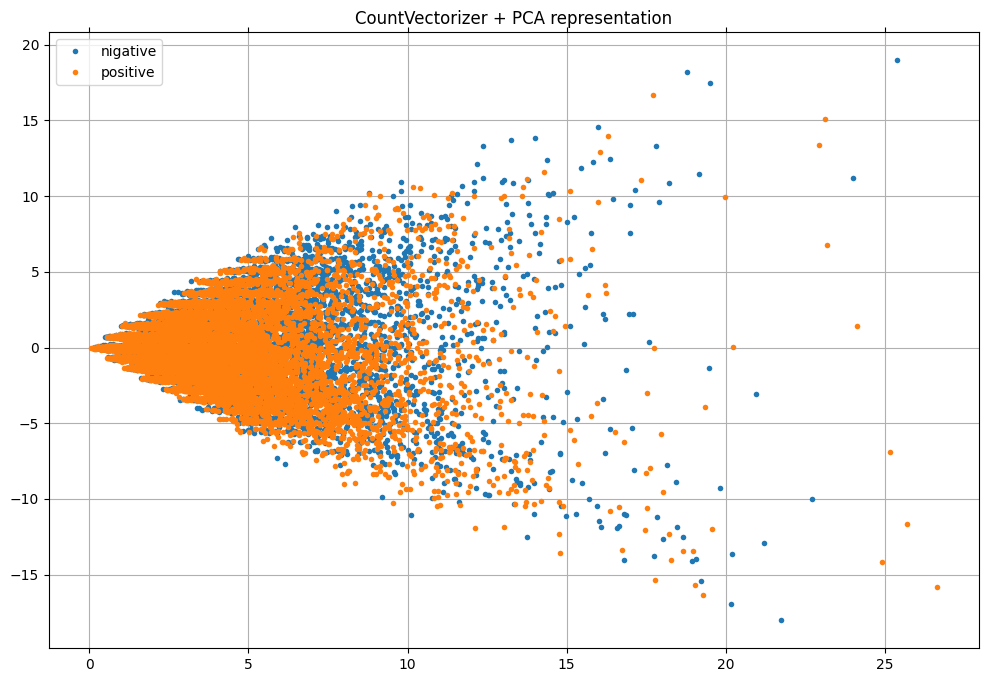

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
for name, group in groups:
  ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=cluster_names[int(name)], color=cluster_colors[int(name)], mec='none')
  ax.set_aspect('auto')
  ax.tick_params(        axis= 'x',
      which='both',
      bottom='off',
      top='off',
      labelbottom='off')
  ax.tick_params(        axis= 'y',
      which='both',
      left='off',
      top='off',
      labelleft='off')
plt.grid(which='both')
plt.title(f'CountVectorizer + PCA representation')
ax.legend(numpoints=1)
plt.show()

In [ ]:
data_final_cv = vectorizer.transform(data_test['text_lemmas'])

## Tf-Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1, 2))
data_vec_tf_idf = vec.fit_transform(data['text_lemmas'])

### Посмотрим на данные

In [ ]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2)

In [ ]:
pca.fit(data_vec_tf_idf)

TruncatedSVD()

In [ ]:
data_2  = pca.transform(data_vec_tf_idf)

In [ ]:
df = pd.DataFrame(dict(x=data_2[:,0], y=data_2[:,1],label=data['label'].tolist()))
groups = df.groupby('label',sort=False)

In [ ]:
#cluster_colors = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green', 4: 'tab:red', 6: 'tab:purple', 7:'tab:brown', 8: 'tab:gray', 9: 'tab:olive', 10: 'tab:cyan'}
#cluster_names = {1: '1', 2: '2', 3: '3', 4: '4', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10'}
cluster_colors = {0: 'tab:blue', 1: 'tab:orange'}
cluster_names = {0: 'nigative', 1: 'positive'}

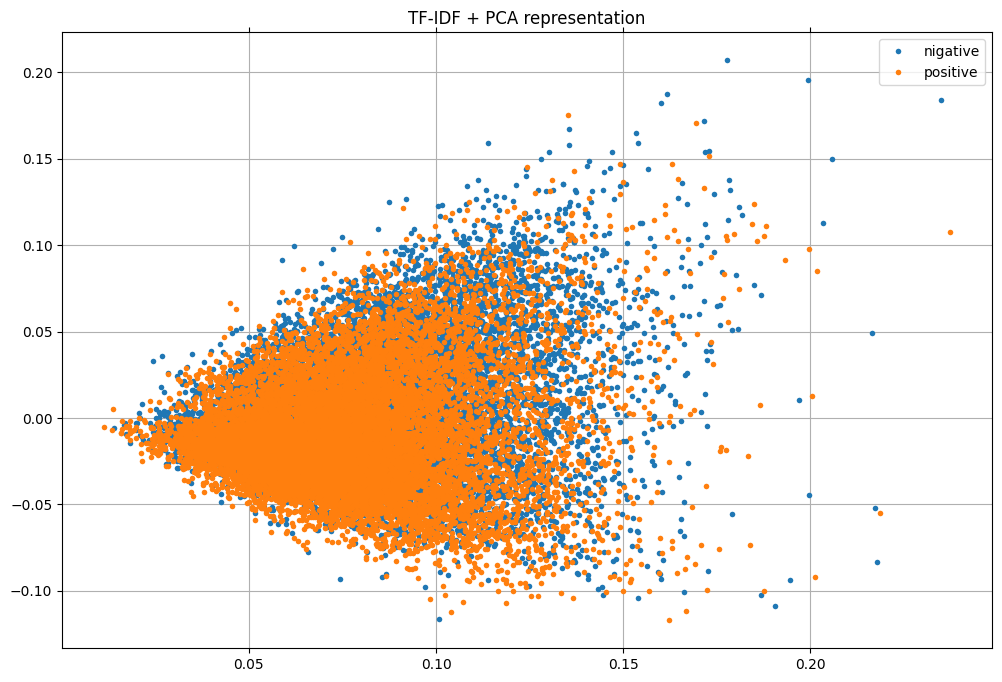

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
for name, group in groups:
  ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=cluster_names[int(name)], color=cluster_colors[int(name)], mec='none')
  ax.set_aspect('auto')
  ax.tick_params(
      axis= 'x',
      which='both',
      bottom='off',
      top='off',
      labelbottom='off')
  ax.tick_params(
      axis= 'y',
      which='both',
      left='off',
      top='off',
      labelleft='off')
plt.grid(which='both')
plt.title(f'TF-IDF + PCA representation')
ax.legend(numpoints=1)
plt.show()

In [ ]:
data_final_tf_idf = vec.transform(data_test['text_lemmas'])

## Word2Vec

In [ ]:
data

,text,score,label,text_lemmas
0,"Definitely the product of young minds, this pi...",3,0,definitely product young minds piece well appe...
1,I liked this movie a lot. The animation was we...,10,1,liked movie animation well done romance cute l...
2,A complete waste of time<br /><br />Halla Bol ...,2,0,complete waste time halla complete waste time ...
3,By 1987 Hong Kong had given the world such fil...,9,1,hong kong given world films sammo hung `encoun...
4,This is the start of a new and interesting Sta...,9,1,start interesting star trek series earth kind ...
...,...,...,...,...
24995,"I remember Casper comic books, but don't remem...",7,1,remember casper comic books remember cartoons ...
24996,Dreadful acting. A thinly veiled attempt to sl...,1,0,dreadful acting thinly veiled attempt slam lef...
24997,First off to get my own personal feelings out ...,1,0,first personal feelings start saying hate call...
24998,It is a great movie. i sow that some people th...,10,1,great movie people think might based true stor...


In [ ]:
#import gensim.downloader as api
#path = api.load("word2vec-google-news-300", return_path=True)
#print(path)

In [ ]:
import gensim

# Load Google's pre-trained Word2Vec model.
#model = gensim.models.KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)

In [ ]:
train_text = [sample.split() for sample in data['text_lemmas']]

In [ ]:
vector_size=300
model = gensim.models.Word2Vec(train_text,vector_size=vector_size,window=5,min_count=5,workers=15,epochs=25)

In [ ]:
def FunctionText2Vec(inpTextData):
    W2Vec_Data=pd.DataFrame()
    for i in range(inpTextData.shape[0]):
      print(i,'/',inpTextData.shape[0])
      Sentence = np.zeros(vector_size)
      for word in inpTextData[i].split():
          if word in model.wv.index_to_key:
              Sentence=Sentence+model.wv[word]
      W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return W2Vec_Data

In [ ]:
data_vec = FunctionText2Vec(np.array(data['text_lemmas']))

Выходные данные были обрезаны до нескольких последних строк (5000).
20000 / 25000
20001 / 25000
20002 / 25000
20003 / 25000
20004 / 25000
20005 / 25000
20006 / 25000
20007 / 25000
20008 / 25000
20009 / 25000
20010 / 25000
20011 / 25000
20012 / 25000
20013 / 25000
20014 / 25000
20015 / 25000
20016 / 25000
20017 / 25000
20018 / 25000
20019 / 25000
20020 / 25000
20021 / 25000
20022 / 25000
20023 / 25000
20024 / 25000
20025 / 25000
20026 / 25000
20027 / 25000
20028 / 25000
20029 / 25000
20030 / 25000
20031 / 25000
20032 / 25000
20033 / 25000
20034 / 25000
20035 / 25000
20036 / 25000
20037 / 25000
20038 / 25000
20039 / 25000
20040 / 25000
20041 / 25000
20042 / 25000
20043 / 25000
20044 / 25000
20045 / 25000
20046 / 25000
20047 / 25000
20048 / 25000
20049 / 25000
20050 / 25000
20051 / 25000
20052 / 25000
20053 / 25000
20054 / 25000
20055 / 25000
20056 / 25000
20057 / 25000
20058 / 25000
20059 / 25000
20060 / 25000
20061 / 25000
20062 / 25000
20063 / 25000
20064 / 25000
20065 / 25000
20066 / 

In [ ]:
data_vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,17.504229,-23.389273,-35.740672,-67.549721,16.222092,5.579311,-8.886672,-46.141381,-53.101903,-9.855610,...,13.204406,-33.225174,-30.354820,16.826980,36.054835,-32.004220,4.769594,29.207342,2.398491,-21.244259
0,5.112908,2.653794,-10.224479,-7.371002,1.335526,-16.159582,4.518454,-8.895911,-3.038967,3.589492,...,0.666994,6.291175,-8.239606,0.358032,3.626247,-1.308543,-0.953837,8.880711,-1.873176,9.868726
0,2.214721,-49.133272,-28.047364,-76.332063,10.162234,29.082684,-39.833391,-83.905762,-63.326097,0.197440,...,21.484403,-9.260412,-37.973518,15.364182,34.618713,-22.704277,-3.860045,60.897281,-9.233253,-23.004928
0,-44.195473,-63.762860,-71.678506,-60.591479,140.447569,-23.988204,69.995420,-101.170599,-77.013593,11.095468,...,-5.456632,50.962234,-88.235164,103.203649,68.757422,-91.875060,-65.712440,123.771877,59.219619,-12.654994
0,-12.194713,-3.891771,-19.827691,-42.548863,4.470033,4.076037,-20.446649,-10.771498,-14.033032,3.018770,...,-12.459054,-19.023334,-2.681855,18.384012,17.453822,-7.668396,18.619919,9.850801,-7.486994,-1.688119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-9.471096,-36.721067,-20.389052,-25.045815,-6.622935,27.311304,-35.227523,-59.751560,-33.376599,-21.387544,...,-13.937965,-20.420307,-12.348171,-1.120238,27.499333,1.431523,-3.224927,-4.093797,22.853642,23.034650
0,4.088295,-7.102328,-0.624914,-1.934712,1.704373,-7.064902,1.487728,-4.932459,-0.567464,-1.711583,...,-4.494154,-4.104776,-0.864437,-2.505161,-2.384447,-4.043018,-5.213823,5.475256,-0.720129,-4.660444
0,-20.831616,-131.549543,-101.313208,-158.714953,-27.084202,122.166507,-104.642921,-215.126001,-97.699837,-37.353117,...,0.719045,-46.839300,-75.381641,50.220081,70.743756,-83.268373,-26.470462,121.488385,-33.866133,-7.660519
0,-8.085322,-31.263523,-19.728718,-41.937915,4.148078,32.469430,-18.022302,-54.212613,-39.741496,-1.363189,...,-8.328351,-7.105375,-28.246467,7.615639,-3.109722,0.265046,-12.189955,30.139316,-4.927809,0.795975


### Посмотрим на данные

In [ ]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2)

In [ ]:
pca.fit(data_vec)

TruncatedSVD()

In [ ]:
data_2  = pca.transform(data_vec)

In [ ]:
df = pd.DataFrame(dict(x=data_2[:,0], y=data_2[:,1],label=data['label'].tolist()))
groups = df.groupby('label',sort=False)

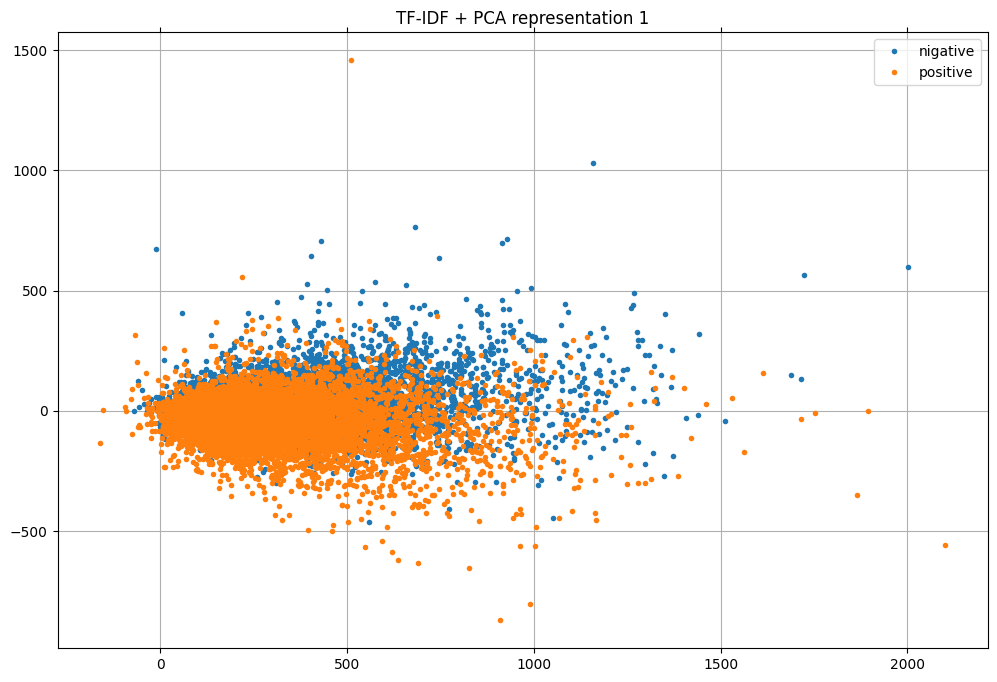

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
for name, group in groups:
  ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=cluster_names[int(name)], color=cluster_colors[int(name)], mec='none')
  ax.set_aspect('auto')
  ax.tick_params(
      axis= 'x',
      which='both',
      bottom='off',
      top='off',
      labelbottom='off')
  ax.tick_params(
      axis= 'y',
      which='both',
      left='off',
      top='off',
      labelleft='off')
plt.grid(which='both')
plt.title(f'TF-IDF + PCA representation {name}')
ax.legend(numpoints=1)
plt.show()

In [ ]:
data_final_w2v = FunctionText2Vec(np.array(data_test['text_lemmas']))

Выходные данные были обрезаны до нескольких последних строк (5000).
20000 / 25000
20001 / 25000
20002 / 25000
20003 / 25000
20004 / 25000
20005 / 25000
20006 / 25000
20007 / 25000
20008 / 25000
20009 / 25000
20010 / 25000
20011 / 25000
20012 / 25000
20013 / 25000
20014 / 25000
20015 / 25000
20016 / 25000
20017 / 25000
20018 / 25000
20019 / 25000
20020 / 25000
20021 / 25000
20022 / 25000
20023 / 25000
20024 / 25000
20025 / 25000
20026 / 25000
20027 / 25000
20028 / 25000
20029 / 25000
20030 / 25000
20031 / 25000
20032 / 25000
20033 / 25000
20034 / 25000
20035 / 25000
20036 / 25000
20037 / 25000
20038 / 25000
20039 / 25000
20040 / 25000
20041 / 25000
20042 / 25000
20043 / 25000
20044 / 25000
20045 / 25000
20046 / 25000
20047 / 25000
20048 / 25000
20049 / 25000
20050 / 25000
20051 / 25000
20052 / 25000
20053 / 25000
20054 / 25000
20055 / 25000
20056 / 25000
20057 / 25000
20058 / 25000
20059 / 25000
20060 / 25000
20061 / 25000
20062 / 25000
20063 / 25000
20064 / 25000
20065 / 25000
20066 / 

# Фичи

In [ ]:
X = data_vec_tf_idf
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif ,SelectPercentile

In [ ]:
bestfeatures = SelectPercentile(score_func = chi2)
fit = bestfeatures.fit(X_train, y_train)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(np.arange(X_train.shape[1]))

In [ ]:
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']

In [ ]:
n = featureScores.nlargest(300, 'Score')

In [ ]:
print(featureScores.nlargest(300, 'Score'))

           Specs      Score
1718735  1718735  45.945304
1665726  1665726  33.938545
109001    109001  30.254810
662222    662222  26.325323
1530627  1530627  24.265352
...          ...        ...
898542    898542   3.048642
116596    116596   3.024974
450802    450802   3.021229
727209    727209   3.015183
547193    547193   3.005627

[300 rows x 2 columns]


In [ ]:
arr = np.array(n['Specs'])

In [ ]:
arr

In [ ]:
arr_name = vec.get_feature_names_out()

In [ ]:
for i in arr:
  print(arr_name[i], '-', featureScores.Score[i])

worst - 45.945304136213636
waste - 33.938545188355945
awful - 30.254809786993782
great - 26.325323364525488
terrible - 24.265351688074453
waste time - 23.465849930367284
boring - 21.78749254573836
horrible - 20.596037732585998
stupid - 20.270330741399356
worse - 19.862863321783493
wonderful - 19.861036703215625
excellent - 18.678545404297775
crap - 16.499968383279484
poor - 16.03222821247743
lame - 14.695683072402494
worst movie - 14.389844614523774
nothing - 14.091550855639232
love - 13.889827247354816
poorly - 13.54652261215947
minutes - 12.472687265269421
avoid - 12.442410043013808
pointless - 12.431557757096797
perfect - 12.166758170222883
best - 12.116710375619487
ridiculous - 12.107085038871748
amazing - 11.960875631633296
supposed - 11.626572657007927
favorite - 11.313795137149226
loved - 11.14377169922636
superb - 11.031273104392543
money - 10.673403307076029
dull - 10.647388540407876
wasted - 10.324442972117886
badly - 10.322278727485143
plot - 10.20574248220181
script - 10.09

Добавим эти фичи в `Catboost`

# Models Classification

In [28]:
from sklearn.metrics import accuracy_score

In [31]:
scores_Accuracy = {}

In [ ]:
final_test = data_test['label']

## Baseline (SVMs with liniar kernel)

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
X = data_vec_cv
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf_1 = LinearSVC()
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['Baseline + CountVectorizer'] = accuracy_score(y_pred, y_val)

y_pred = clf_1.predict(data_final_cv)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8470666666666666
Final Accuracy: 0.83532


In [ ]:
X = data_vec_tf_idf
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf_1 = LinearSVC()
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['Baseline + TF-IDF'] = accuracy_score(y_pred, y_val)

y_pred = clf_1.predict(data_final_tf_idf)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8986666666666666
Final Accuracy: 0.88268


In [ ]:
X = data_vec
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf_1 = LinearSVC()
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['Baseline + Word2Vec'] = accuracy_score(y_pred, y_val)

y_pred = clf_1.predict(data_final_w2v)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.7978666666666666
Final Accuracy: 0.789


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = data_vec_cv
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['LogisticRegression + CountVectorizer']  = accuracy_score(y_pred, y_val)

y_pred = clf.predict(data_final_cv)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8724
Final Accuracy: 0.85616


In [ ]:
X = data_vec_tf_idf
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['LogisticRegression + TF-IDF'] = accuracy_score(y_pred, y_val)

y_pred = clf.predict(data_final_tf_idf)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8750666666666667
Final Accuracy: 0.86808


In [ ]:
X = data_vec
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['LogisticRegression + Word2Vec'] = accuracy_score(y_pred, y_val)

y_pred = clf.predict(data_final_w2v)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8736
Final Accuracy: 0.8718


## SVMs with polynomial kernel

In [ ]:
from sklearn.svm import SVC

In [ ]:
X = data_vec_cv
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['SVM polynomial kernel + CountVectorizer'] = accuracy_score(y_pred, y_val)


y_pred = model.predict(data_final_cv)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8669333333333333
Final Accuracy: 0.86044


In [ ]:
X = data_vec_tf_idf
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)


print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['SVM polynomial kernel + TF-IDF'] = accuracy_score(y_pred, y_val)
y_pred = model.predict(data_final_tf_idf)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8873333333333333
Final Accuracy: 0.8748


In [ ]:
X = data_vec
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)


print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['SVM polynomial kernel + TF-IDF'] = accuracy_score(y_pred, y_val)

y_pred = model.predict(data_final_w2v)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8804
Final Accuracy: 0.87436


## Random Forest

In [ ]:
X = data_vec_cv
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['Random Forest + CountVectorizer'] = accuracy_score(y_pred, y_val)

y_pred = model.predict(data_final_cv)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8550666666666666
Final Accuracy: 0.847


In [ ]:
X = data_vec_tf_idf
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)


print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['Random Forest + TF-IDF'] = accuracy_score(y_pred, y_val)

y_pred = model.predict(data_final_tf_idf)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8461333333333333
Final Accuracy: 0.846


In [ ]:
X = data_vec
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['Random Forest + Word2Vec'] = accuracy_score(y_pred, y_val)

y_pred = model.predict(data_final_w2v)

print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8322666666666667
Final Accuracy: 0.826


## LightGBM


In [ ]:
import lightgbm as lgb

In [ ]:
X = data_vec_cv.astype('float32')
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['LightGBM + CountVectorizer'] = accuracy_score(y_pred, y_val)

y_pred = clf.predict(data_final_cv.astype('float32'))
print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8606666666666667
Final Accuracy: 0.85364


In [ ]:
X = data_vec_tf_idf.astype('float32')
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['LightGBM + TF-IDF'] = accuracy_score(y_pred, y_val)

y_pred = clf.predict(data_final_tf_idf.astype('float32'))
print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8486666666666667
Final Accuracy: 0.85088


In [ ]:
X = data_vec.astype('float32')
y = data['label']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)


clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print('Accuracy:',accuracy_score(y_pred, y_val))
scores_Accuracy['LightGBM + Word2Vec'] = accuracy_score(y_pred, y_val)

y_pred = clf.predict(data_final_w2v.astype('float32'))
print('Final Accuracy:',accuracy_score(y_pred, final_test))

Accuracy: 0.8553333333333333
Final Accuracy: 0.85328


## CatBoost

In [13]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.1 MB/s eta 0:00:00


In [9]:
data

,text,score,label
0,In my opinion this movie advances no new thoug...,3,0
1,I scooped up this title by accident with the G...,8,1
2,"This movie isn't very good. It's boring, and n...",3,0
3,Kabei: Our Mother (2008) is a poetic and subli...,10,1
4,"""Ardh Satya"" is one of the finest film ever ma...",8,1
...,...,...,...
24995,Once again the two bickering professors must j...,10,1
24996,Italian horror/suspense film about a wealthy E...,4,0
24997,"one may ask why? the characters snarl, yell, a...",1,0
24998,"after just having watched The Deer Hunter,whic...",10,1


In [35]:
X = data[['text_lemmas','text']]
y = data['label']
train, val, y_train, y_test = tts(X, y, stratify=y, train_size=0.7, random_state=42)
test = data_test[['text_lemmas','text']]

In [ ]:
for i in arr:
  train[f'feature_{arr_name[i]}'] = X_train[:, i].toarray()
  val[f'feature_{arr_name[i]}'] = X_val[:, i].toarray()
  test[f'feature_{arr_name[i]}'] =data_final_tf_idf[:, i].toarray()

In [17]:
df_train = train
df_val = val
df_test = test

In [18]:
df_test

,text_lemmas,text
0,eighteen tells story anders depressed extremel...,"""Eighteen"" (2004) tells the story of Pip Ander..."
1,afraid name long list people remain flabbergas...,I am afraid I will have to add my name to the ...
2,read paolo sorrintino inspiration consequences...,I've read that Paolo Sorrintino's inspiration ...
3,copy cats copied movie hindi movie called call...,Copy cats have copied this movie from a 1974 H...
4,really excited read canterville ghost would sh...,"I was really excited when I read ""The Cantervi..."
...,...,...
24995,least feel pretty high movie kind film word ro...,Or at least you feel pretty high after this mo...
24996,least following career almdovar since beginnin...,At least for me. I have been following the car...
24997,knew little movie entered theatre advance scre...,I knew little of this movie when I entered the...
24998,nice scenery look keep eyes open long enough s...,"There's some nice scenery to look at here,if y..."


Добавим фичу длинна всего отзыва

In [19]:
df_train['sym_len'] = train.text_lemmas.apply(len)
df_train['word_len'] = train.text_lemmas.apply(lambda x: len(x.split()))

df_test['sym_len'] = test.text_lemmas.apply(len)
df_test['word_len'] = test.text_lemmas.apply(lambda x: len(x.split()))

df_val['sym_len'] = val.text_lemmas.apply(len)
df_val['word_len'] = val.text_lemmas.apply(lambda x: len(x.split()))

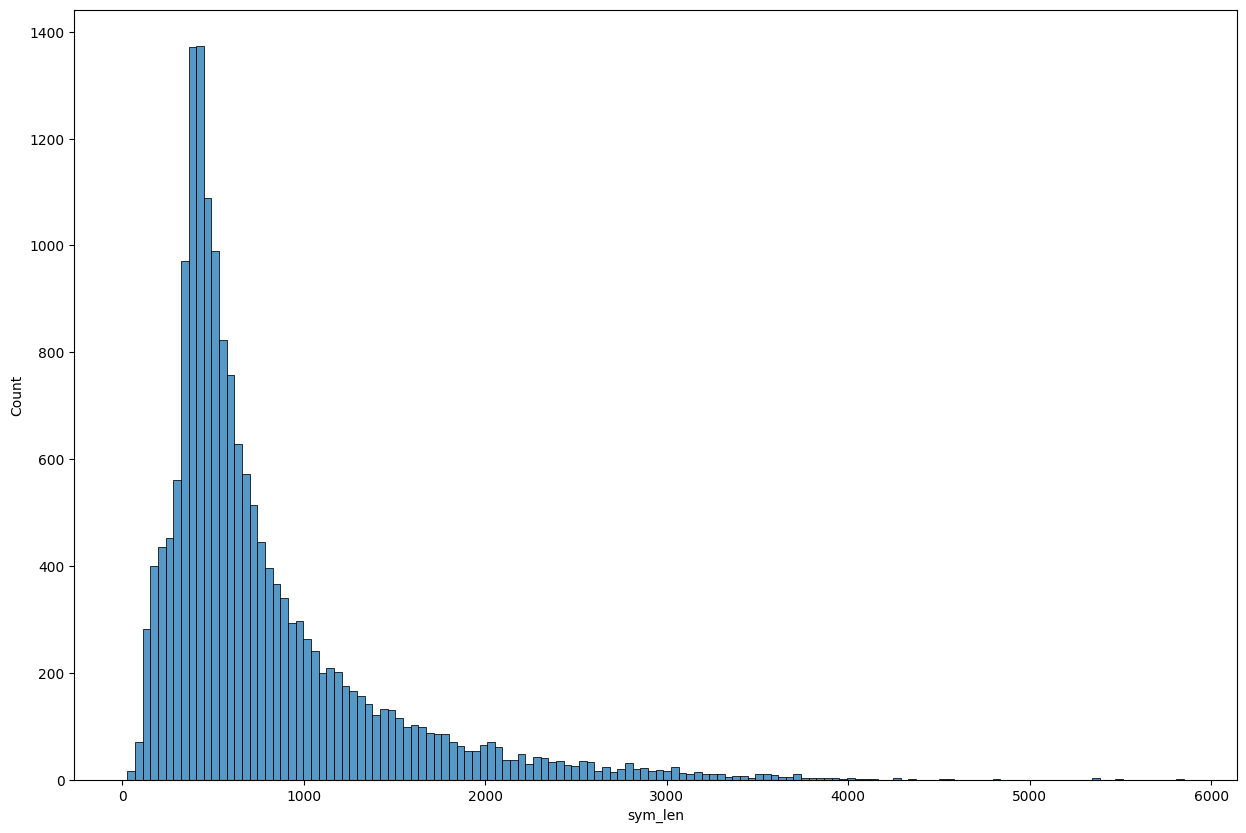

In [20]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df_train.sym_len)
plt.show()

Вимдим, что распредление с длинным хвостом, поэтому логорифмируем эти фичи

In [21]:
df_train['sym_len'] = np.log(df_train['sym_len'])
df_train['word_len'] = np.log(df_train['word_len'])
df_val['sym_len'] = np.log(df_val['sym_len'])
df_val['word_len'] = np.log(df_val['word_len'])
df_test['sym_len'] = np.log(df_test['sym_len'])
df_test['word_len'] = np.log(df_test['word_len'])

In [22]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        eval_metric='Accuracy',
        iterations=10000,
        learning_rate=0.05,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

In [23]:
train_pool = Pool(
    df_train, y_train,
    text_features=['text','text_lemmas'],
)

test_pool = Pool(
    df_test,
    text_features=['text','text_lemmas'],
)

val_pool = Pool(
    df_val, y_test,
    text_features=['text','text_lemmas'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model_cat_boost = fit_model(train_pool, val_pool)

Train dataset shape: (17500, 4)

0:	learn: 0.8460000	test: 0.8605333	best: 0.8605333 (0)	total: 88.6ms	remaining: 14m 45s
500:	learn: 0.9130286	test: 0.8898667	best: 0.8905333 (482)	total: 25.9s	remaining: 8m 10s
1000:	learn: 0.9343429	test: 0.8960000	best: 0.8962667 (977)	total: 50.4s	remaining: 7m 33s
1500:	learn: 0.9469143	test: 0.8977333	best: 0.8977333 (1498)	total: 1m 20s	remaining: 7m 35s
2000:	learn: 0.9584571	test: 0.8989333	best: 0.8994667 (1944)	total: 1m 45s	remaining: 7m 1s
2500:	learn: 0.9655429	test: 0.8997333	best: 0.9000000 (2450)	total: 2m 7s	remaining: 6m 22s
3000:	learn: 0.9712571	test: 0.8985333	best: 0.9000000 (2450)	total: 2m 31s	remaining: 5m 54s
3500:	learn: 0.9758857	test: 0.8990667	best: 0.9000000 (2450)	total: 2m 52s	remaining: 5m 20s
4000:	learn: 0.9798286	test: 0.8996000	best: 0.9000000 (2450)	total: 3m 16s	remaining: 4m 55s
4500:	learn: 0.9834857	test: 0.8996000	best: 0.9000000 (2450)	total: 3m 43s	remaining: 4m 33s
5000:	learn: 0.9863429	test: 0.8988000	

In [24]:
model_cat_boost.save_model('classifire_model_MVP.cbm')

from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.load_model('classifire_model_MVP.cbm')

In [25]:
y_pred = model.predict(test_pool)

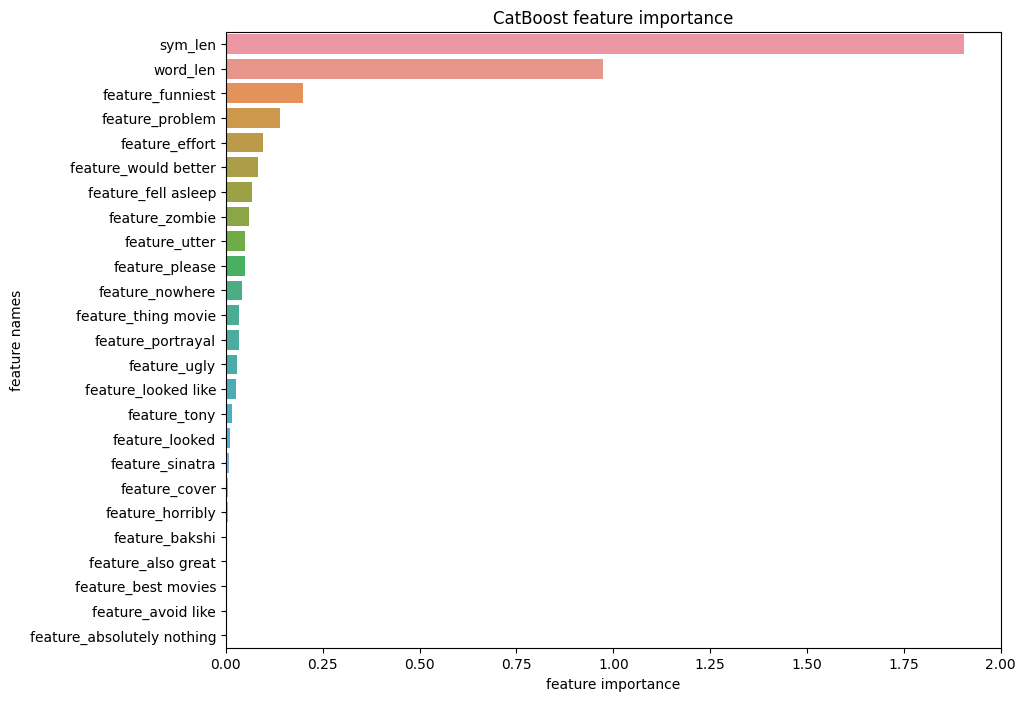

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data).tail(25)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')
plot_feature_importance(model_cat_boost .get_feature_importance(),df_train.columns,'CatBoost ')

In [ ]:
y_pred = model_cat_boost.predict(test_pool)

In [29]:
y_test = data_test['label']

In [32]:
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Catboost'] = accuracy_score(y_pred, y_test)

Accuracy: 0.88428


## BERT

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.31.0
Uninstalling transformers-4.31.0:
  Successfully uninstalled transformers-4.31.0
  Using cached transformers-4.31.0-py3-none-any.whl (7.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForPreTraining,AutoModel

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model_name = "bert-base-multilingual-cased"

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_base = AutoModel.from_pretrained(model_name).to(device)

In [ ]:
data['text_f'] = data.apply(lambda x: " [CLS] " + x.text.replace(".", " [SEP] "), axis=1)
data.sample(10)

,text,score,label,text_f
16560,I came away from this movie with the feeling t...,4,0,[CLS] I came away from this movie with the fe...
10876,I can understand those who dislike this movie ...,10,1,[CLS] I can understand those who dislike this...
15889,"The original movie, Man From Snowy River, is o...",1,0,"[CLS] The original movie, Man From Snowy Rive..."
12920,"This film is excellently paced, you never have...",8,1,"[CLS] This film is excellently paced, you nev..."
13565,Let's be honest here: the only reason anyone b...,1,0,[CLS] Let's be honest here: the only reason a...
7450,"Chalk this one up in the win column, this was ...",9,1,"[CLS] Chalk this one up in the win column, th..."
14553,This is the biggest piece of lamo I've ever wa...,1,0,[CLS] This is the biggest piece of lamo I've ...
19048,"My Comments for VIVAH :- Its a charming, ideal...",10,1,[CLS] My Comments for VIVAH :- Its a charming...
3840,Absolutely horrific film. Ameteurish and it is...,1,0,[CLS] Absolutely horrific film [SEP] Ameteur...
23650,"When it comes to movies, I am generally easily...",1,0,"[CLS] When it comes to movies, I am generally..."


In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embeds(text, model, tokenizer):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings[0].to('cpu')

In [ ]:
data['embedding'] = data['text_f'].apply(get_embeds, model=model_base, tokenizer=tokenizer)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data['text_f'], data['label'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)
all_encodings = tokenizer(data['text_f'].tolist(), truncation=True, padding=True)

In [ ]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)
all_dataset = GroupsDataset(all_encodings, data['label'])

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    f1_nigative = f1_score(labels, preds, pos_label=0)
    f1_positive = f1_score(labels, preds, pos_label=1)
    return {
            'f1 macro'      : f1,
            'f1 positive'   : f1_positive,
            'f1 nigative'   : f1_nigative
            }

### train

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=5e-5,#-5
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=250,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=250,
    save_steps=250,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1 macro,F1 positive,F1 nigative
250,0.533700,0.468446,0.802038,0.828090,0.775986
500,0.413200,0.344398,0.862947,0.868832,0.857063
750,0.370900,0.417649,0.866931,0.867534,0.866327
1000,0.365800,0.348066,0.876618,0.874167,0.879069
1250,0.296200,0.302380,0.890646,0.889159,0.892134
1500,0.248300,0.338793,0.884953,0.881333,0.888573
1750,0.250100,0.304841,0.859229,0.845677,0.872780
2000,0.240000,0.341863,0.901999,0.902352,0.901646
2250,0.239300,0.404773,0.872249,0.882469,0.862029
2500,0.181200,0.334153,0.897371,0.894237,0.900505


TrainOutput(global_step=4376, training_loss=0.22784191184767422, metrics={'train_runtime': 5164.5098, 'train_samples_per_second': 13.554, 'train_steps_per_second': 0.847, 'total_flos': 1.84177738752e+16, 'train_loss': 0.22784191184767422, 'epoch': 4.0})

In [ ]:
val_pred = trainer.predict(valid_dataset)

In [ ]:
labels = val_pred[0].argmax(-1)

In [ ]:
print('val Accuracy:',accuracy_score(labels, y_val))

val Accuracy: 0.8906666666666667


### test

In [ ]:
encodings = tokenizer(data_test['text'].tolist(), truncation=True, padding=True)

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings


    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings)

test_dataset = GroupsDataset(encodings, [0 for i in range(len(data_test))])


In [ ]:
test_pred = trainer.predict(test_dataset)

In [ ]:
labels = test_pred[0].argmax(-1)

In [ ]:
print('Final Accuracy:',accuracy_score(labels, final_test))

Final Accuracy: 0.89576



# Models Regression

In [45]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
final_test =np.array(data_test['score']).astype(int)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X = data_vec_cv
y = data['score']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)

arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])

print('MAE:',mean_absolute_error(arr_1, y_val))
print('MAPE:',mean_absolute_percentage_error(arr_1, y_val))

y_pred = reg.predict(data_final_cv)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])

print('Final MAE:',mean_absolute_error(arr_1, final_test))
print('Final MAPE:',mean_absolute_percentage_error(arr_1, final_test))

MAE: 2.6312
MAPE: 0.9247810052910054
Final MAE: 2.7322
Final MAPE: 0.9784462698412698


In [ ]:
X = data_vec_tf_idf
y = data['score']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('MAE:',mean_absolute_error(arr_1, y_val))
print('MAPE:',mean_absolute_percentage_error(arr_1,  y_val))

y_pred = reg.predict(data_final_tf_idf)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('Final MAE:',mean_absolute_error(arr_1, final_test))
print('Final MAPE:',mean_absolute_percentage_error(arr_1, final_test))

MAE: 1.6685333333333334
MAPE: 0.3612971957671958
Final MAE: 1.61004
Final MAPE: 0.38093514285714286


In [ ]:
X = data_vec
y = data['score']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('MAE:',mean_absolute_error(arr_1, y_val))
print('MAPE:',mean_absolute_percentage_error(arr_1, y_val))

y_pred = reg.predict(data_final_w2v)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('Final MAE:',mean_absolute_error(arr_1, final_test))
print('Final MAPE:',mean_absolute_percentage_error(arr_1, final_test))

MAE: 2.0268
MAPE: 0.43323634920634924
Final MAE: 2.09524
Final MAPE: 0.43710984126984126


## LightGBM


In [ ]:
import lightgbm as lgb

In [ ]:
X = data_vec_cv.astype('float32')
y = data['score']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

reg = lgb.LGBMRegressor(

)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('MAE:',mean_absolute_error(arr_1, y_val))
print('MAPE:',mean_absolute_percentage_error(arr_1, y_val))

y_pred = reg.predict(data_final_cv.astype('float32'))
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('Final MAE:',mean_absolute_error(arr_1, final_test))
print('Final MAPE:',mean_absolute_percentage_error(arr_1, final_test))

MAE: 1.7905333333333333
MAPE: 0.38978354497354495
Final MAE: 1.81124
Final MAPE: 0.3940080317460317


In [ ]:
X = data_vec_tf_idf.astype('float32')
y = data['score']
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

reg = lgb.LGBMRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('MAE:',mean_absolute_error(arr_1, y_val))
print('MAPE:',mean_absolute_percentage_error(arr_1, y_val))

y_pred = reg.predict(data_final_tf_idf.astype('float32'))
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('Final MAE:',mean_absolute_error(arr_1, final_test))
print('Final MAPE:',mean_absolute_percentage_error(arr_1, final_test))

MAE: 1.7684
MAPE: 0.3841089947089947
Final MAE: 1.76012
Final MAPE: 0.3924201428571428


In [ ]:
X = data_vec
y = data['score'].astype(int)
X_train, X_val, y_train, y_val = tts(X, y, stratify=y, train_size=0.7,random_state=42)

reg = lgb.LGBMRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('MAE:',mean_absolute_error(arr_1, y_val))
print('MAPE:',mean_absolute_percentage_error(arr_1, y_val))

y_pred = reg.predict(data_final_w2v)
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])
print('Final MAE:',mean_absolute_error(arr_1, final_test))
print('Final MAPE:',mean_absolute_percentage_error(arr_1, final_test))

MAE: 1.7396
MAPE: 0.38501227513227515
Final MAE: 1.77764
Final MAPE: 0.391863253968254


## CatBoost

In [14]:
data

,text,score,label
0,In my opinion this movie advances no new thoug...,3,0
1,I scooped up this title by accident with the G...,8,1
2,"This movie isn't very good. It's boring, and n...",3,0
3,Kabei: Our Mother (2008) is a poetic and subli...,10,1
4,"""Ardh Satya"" is one of the finest film ever ma...",8,1
...,...,...,...
24995,Once again the two bickering professors must j...,10,1
24996,Italian horror/suspense film about a wealthy E...,4,0
24997,"one may ask why? the characters snarl, yell, a...",1,0
24998,"after just having watched The Deer Hunter,whic...",10,1


In [36]:
X = data[['text_lemmas','text']]
y = data['score']
train, val, y_train, y_test = tts(X, y, stratify=y, train_size=0.7, random_state=42)
test = data_test[['text_lemmas','text']]

In [37]:
df_train = train
df_val = val
df_test = test

In [38]:
df_train['sym_len'] = train.text_lemmas.apply(len)
df_train['word_len'] = train.text_lemmas.apply(lambda x: len(x.split()))

df_test['sym_len'] = test.text_lemmas.apply(len)
df_test['word_len'] = test.text_lemmas.apply(lambda x: len(x.split()))

df_val['sym_len'] = val.text_lemmas.apply(len)
df_val['word_len'] = val.text_lemmas.apply(lambda x: len(x.split()))

In [39]:
df_train['sym_len'] = np.log(df_train['sym_len'])
df_train['word_len'] = np.log(df_train['word_len'])

df_val['sym_len'] = np.log(df_val['sym_len'])
df_val['word_len'] = np.log(df_val['word_len'])

df_test['sym_len'] = np.log(df_test['sym_len'])
df_test['word_len'] = np.log(df_test['word_len'])

In [40]:
from catboost import CatBoostRegressor
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostRegressor(
        eval_metric='RMSE',
        iterations=10000,
        learning_rate=0.05,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

In [41]:
train_pool = Pool(
    df_train, y_train,
    text_features=['text','text_lemmas'],
)

test_pool = Pool(
    df_test,
    text_features=['text','text_lemmas'],
)

val_pool = Pool(
    df_val, y_test,
    text_features=['text','text_lemmas'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model_cat_boost = fit_model(train_pool, val_pool)

Train dataset shape: (17500, 4)

0:	learn: 3.4285629	test: 3.4293309	best: 3.4293309 (0)	total: 54.3ms	remaining: 9m 2s
500:	learn: 2.2075549	test: 2.3338408	best: 2.3338408 (500)	total: 12.5s	remaining: 3m 56s
1000:	learn: 2.0300172	test: 2.2580411	best: 2.2579824 (999)	total: 23.9s	remaining: 3m 34s
1500:	learn: 1.9197816	test: 2.2281283	best: 2.2280870 (1499)	total: 35s	remaining: 3m 18s
2000:	learn: 1.8330260	test: 2.2129176	best: 2.2127907 (1997)	total: 44.2s	remaining: 2m 56s
2500:	learn: 1.7584157	test: 2.2022088	best: 2.2021412 (2490)	total: 55.2s	remaining: 2m 45s
3000:	learn: 1.6961370	test: 2.1932047	best: 2.1931686 (2999)	total: 1m 6s	remaining: 2m 34s
3500:	learn: 1.6408774	test: 2.1882636	best: 2.1882476 (3499)	total: 1m 17s	remaining: 2m 24s
4000:	learn: 1.5899684	test: 2.1846764	best: 2.1846093 (3996)	total: 1m 29s	remaining: 2m 13s
4500:	learn: 1.5439954	test: 2.1807134	best: 2.1806081 (4488)	total: 1m 38s	remaining: 2m
5000:	learn: 1.4997222	test: 2.1780024	best: 2.17

In [42]:
y_pred = model_cat_boost.predict(val_pool)

In [43]:
arr = np.round(y_pred, 0).astype(int)
arr_1 = []
for i in range(len(arr)):
  if arr[i]<=0:
    arr_1.append(1)
  elif arr[i]>10:
    arr_1.append(10)
  else:
    arr_1.append(arr[i])

In [46]:
print('val MAE:',mean_absolute_error(arr_1, y_test))
print('val MAPE:',mean_absolute_percentage_error(arr_1, y_test))

val MAE: 1.6518666666666666
val MAPE: 0.3771795767195767


In [47]:
model_cat_boost.save_model('regressor_model_MVP.cbm')

from catboost import CatBoostRegressor
model = CatBoostRegressor()
model.load_model('regressor_model_MVP.cbm')